# Исследование оттока посетителей фитнес-клуба

## Введение

В работе рассматривается работа фитнес-клуба.  

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.  
Чаще всего для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Для анализа и работы с оттоком собраны 4000 клиентских анкет.  
В работе проведён анализ анкет и с помощью алгоритмов машинного обучения:
- спрогнозирована вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформированы типичные портреты клиентов;
- проанализированы основные признаки, наиболее сильно влияющие на отток;
- сформулированы основные выводы и разработаны рекомендации по повышению качества работы с клиентами:
	- выделены целевые группы клиентов;
	- предложены меры по снижению оттока.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
def metrics_to_df(y_true, y_pred, y_proba, model):
    """Функция возвращает таблицу с метриками.

    :param y_true: валидационная выборка
    :param y_pred: предсказанные моделью значения целевого признака
    :param y_proba: вероятность отнесения к рассчитанному классу
    :param model: название модели
    :return: таблица с метриками
    """
    metrics = {
        'model': model,
        'accuracy': round(accuracy_score(y_true, y_pred), 4),
        'precision': round(precision_score(y_true, y_pred), 4),
        'recall': round(recall_score(y_true, y_pred), 4),
        'f1': round(f1_score(y_true, y_pred), 4),
        'roc_auc': round(roc_auc_score(y_true, y_proba), 4), 
    }
    df = pd.DataFrame(data=metrics, index=[0])
    return df

## Исследовательский анализ данных (EDA)

In [3]:
try:
    data = pd.read_csv('gym_churn.csv')
except FileNotFoundError:
    data = pd.read_csv('/datasets/gym_churn.csv')

### Описание полей и исследование значений

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В предоставленных данных 4000 наблюдений и 14 признаков.  
Проверим каждый из них.

In [5]:
data['Month_to_end_contract'] = data['Month_to_end_contract'].astype(int)

In [6]:
# приведём названия столбцов к snake_case 
data.columns = [col.lower().replace(' ', '_') for col in data.columns]

In [7]:
categorical_cols = [
    'gender',
    'near_location',
    'partner', 
    'promo_friends',
    'phone',
    'contract_period',
    'group_visits'
] 
numeric_cols = [
    'age',
    'lifetime','month_to_end_contract',
    'avg_additional_charges_total',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]

In [8]:
# проверка числа уникальных значений
print('Число уникальных значений и сами значения:\n')
for col in data.drop(numeric_cols, axis=1).columns:
    # для определения уникальных значений используем list comprehension
    unique_values = ', '.join(
        str(i) for i in data[col].unique()
        if len(data[col].unique()) <= 3
    )
    # печатаем с отступами и выравниванием по левому краю
    print('{0:<35}{1:<10}{2:<10}'.format(col,
                                    len(list(data[col].unique())),
                                    unique_values
                                   ))

Число уникальных значений и сами значения:

gender                             2         1, 0      
near_location                      2         1, 0      
partner                            2         1, 0      
promo_friends                      2         1, 0      
phone                              2         0, 1      
contract_period                    3         6, 12, 1  
group_visits                       2         1, 0      
churn                              2         0, 1      


Число уникальных значений выглядит логичным для каждого поля.  
Рассмотрим далее числовые поля.

In [9]:
data[numeric_cols].describe()

,age,lifetime,month_to_end_contract,avg_additional_charges_total,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,3.724750,4.322750,146.943728,1.879020,1.767052
std,3.258367,3.749267,4.191297,96.355602,0.972245,1.052906
min,18.000000,0.000000,1.000000,0.148205,0.000000,0.000000
25%,27.000000,1.000000,1.000000,68.868830,1.180875,0.963003
50%,29.000000,3.000000,1.000000,136.220159,1.832768,1.719574
75%,31.000000,5.000000,6.000000,210.949625,2.536078,2.510336
max,41.000000,31.000000,12.000000,552.590740,6.023668,6.146783


**Поле `'age'`**  
Минимальный возраст: 18 лет.  
Максимальный возраст: 41 год.  
Средний возраст: 29 лет — совпадает с медианой.  

**Поле `'lifetime'`**  
Среднее время с момента обращения в фитнес-центр: 3.72 месяца.  
Максимальное время 31 месяц. Можем предположить, что фитнесу скоро 3 года.  

**Поле `'month_to_end_contract'`**  
От 1 до 12 месяцев до завершения действия контракта.  
в среднем 4 месяца, только  25% клиентов в запасе 6 месяцев.  

**Поле `'avg_additional_charges_total'`**  
Суммарная выручка от дополнительных услуг в среднем 146 у.е., что почти совпадает с медианой.
Разброс значений выручки от 0 до 552 у.е.

**Поле `'avg_class_frequency_total'`**  
Средняя частота посещений за весь период, разброс от 0 до 6.02 раз в неделю.
В среднем 1.88.

**Поле `'avg_class_frequency_current_month'`**  
Средняя частота посещений за текущий месяц отличается от частоты за весь период.  
Разброс от 0 до 6.14, в среднем 1.77.

### Группировка по оттоку — `'churn'`

Перейдём к анализу оттока.  
Для начала сгруппируем все данные по оттоку и посчитаем средние значения показателей. 

In [10]:
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По группировке можно сказать, что в отток больше уходят клиенты:
- более молодые;
- с меньшими сопутствующими тратами;
- с меньшей средней посещаемостью;
- с меньшим lifetime;
- с меньшим посещением групповых занятий;
- с меньшим периодом до завершения контракта.

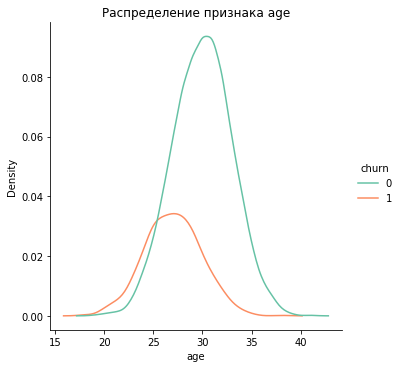

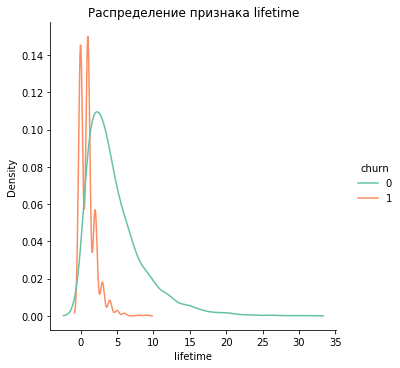

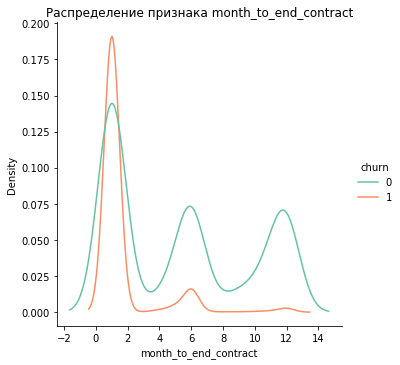

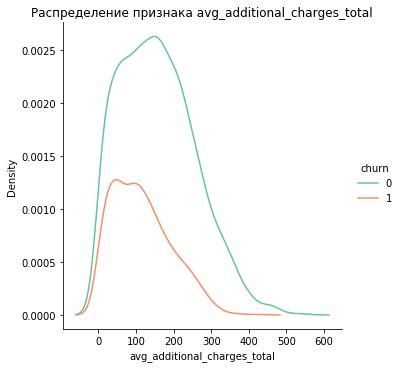

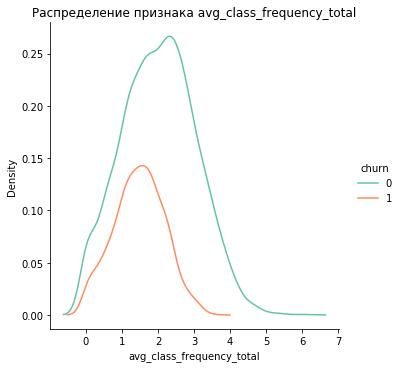

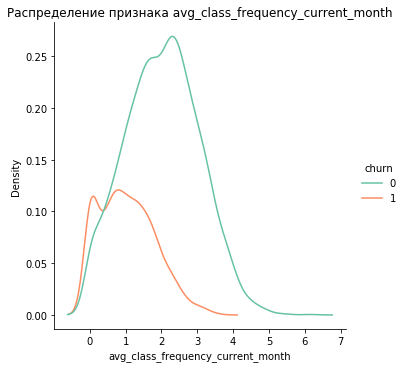

In [11]:
# графики для категориальных переменных
for column in numeric_cols:
    sns.displot(
        x = data[column],
        hue='churn',
        kind="kde",
        data=data,
        palette='Set2'
    )
    plt.title('Распределение признака ' + column)
    plt.show()

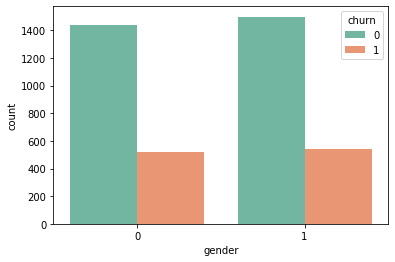

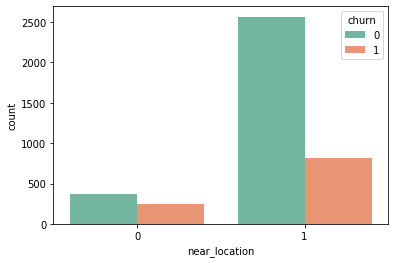

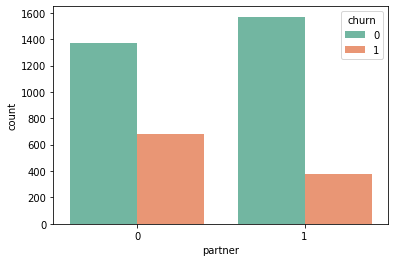

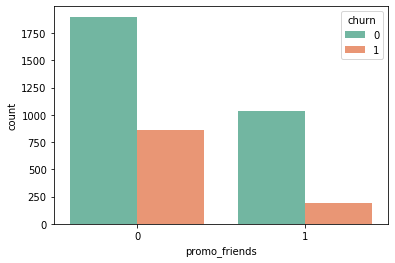

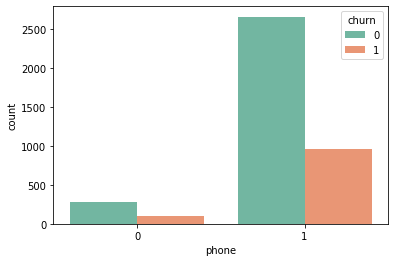

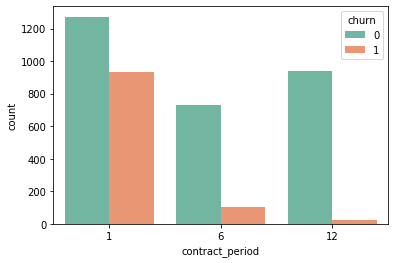

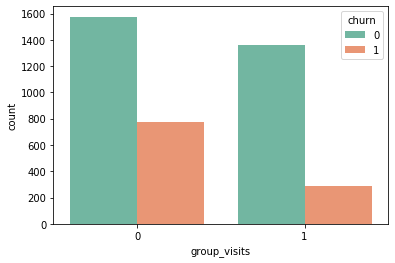

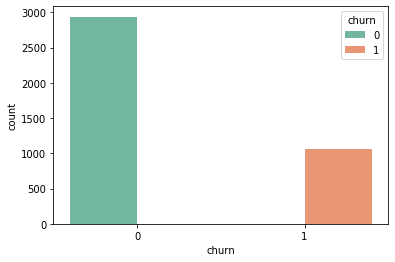

In [12]:
# категориальные поля для клиентов в оттоке и нет
for col in data.drop(numeric_cols, axis=1).columns:
    sns.countplot(x=col, data=data, hue='churn', palette='Set2')
    plt.show()

**Выводы по графикам**  
В оттоке оказываются клиенты:
- с коротким сроком контракта
- не посещающие групповые занятия
- с меньшими тратами на сопутствующие услуги
- с меньшим lifetime
- с меньшей средней посещаемостью

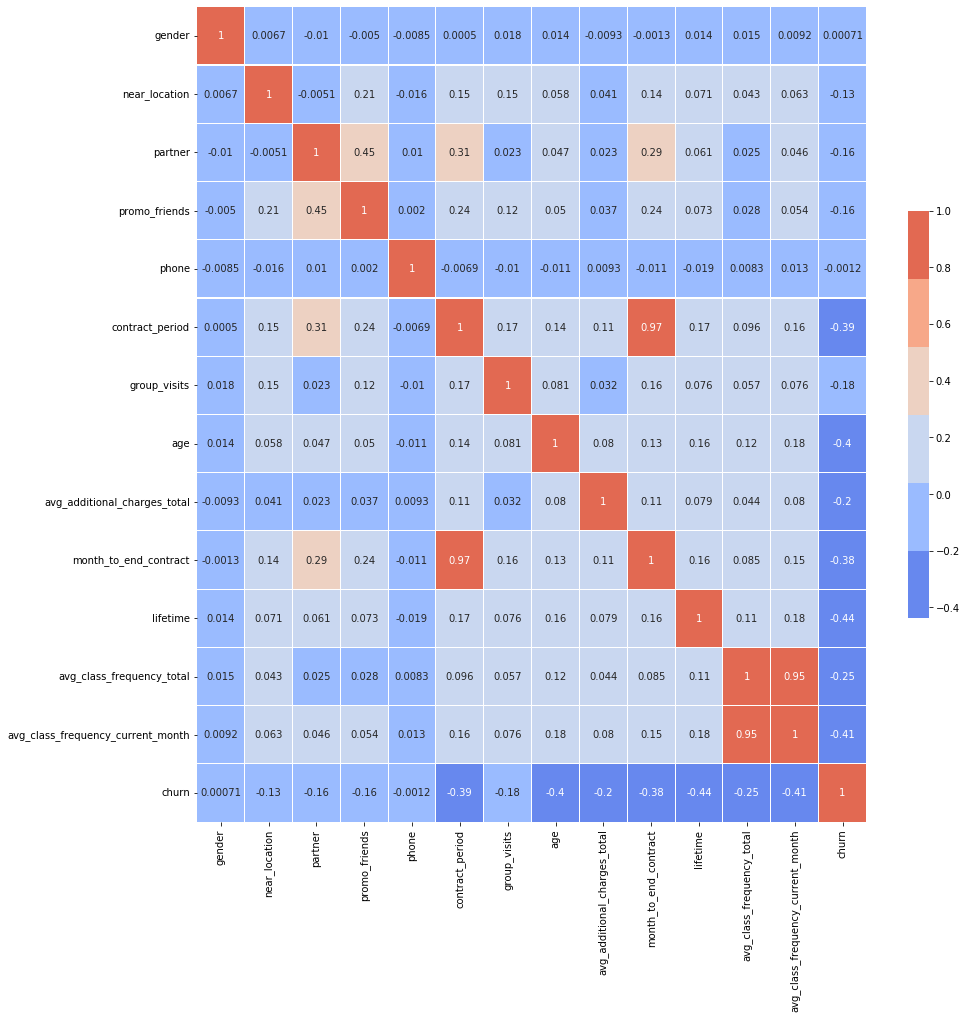

In [13]:
# матрица корреляций
cm = data.corr()

fig, ax = plt.subplots(figsize=(15,15))

sns.heatmap(cm,
            annot=True,
            cmap=sns.color_palette('coolwarm'),
            cbar_kws={'shrink': .5},
            linewidths=.05,
            ax=ax)


plt.show()

**Вывод по матрице корреляций**  
С фактом оттока сильнее всего коррелируют:
- lifetime
- avg_class_frequency_current_month
- age
- contract_period
- month_to_end_contract

Мультиколлинеарность признаков:
- month_to_end_contract и contract_period, корреляция 0.95
- avg_class_frequency_total и avg_class_frequency_current_month, корреляция 0.97


## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.  
Сравним её с моделью случайного леса.  

При разбиении данных из матицы наблюдений уберём мультиколлинеарные признаки.  
Оставим:
- month_to_end_contract
- avg_class_frequency_current_month

In [14]:
# разбиваем данные на признаки и целевой показатель churn
# сразу удаляем мультиколлинеарные признаки
X = data.drop(['churn', 'contract_period', 'avg_class_frequency_total'], axis = 1)
y = data['churn']

In [15]:
# разбиваем данные на обучающую и валидационную выборки 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающую и валидационную выборки
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# задаём алгоритмы для наших моделей
lr_model = LogisticRegression(solver='liblinear')
rf_model = RandomForestClassifier(random_state = 0)

# обучаем модели на соответствующей выборке
lr_model.fit(X_train_st, y_train)
rf_model.fit(X_train, y_train)

# составляем прогноз на основе обученных моделей
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [16]:
# метрики для бинарной классификации
logistic_regression_metrics = metrics_to_df(
    y_test,
    lr_predictions,
    lr_probabilities,
    'Logistic Regression'
)

# метрики для случайного леса
random_forest_metrics = metrics_to_df(
    y_test,
    rf_predictions,
    rf_probabilities,
    'Random Forest'
)

# соединим в одну таблицу для сравнения метрик
models_compare = (
    logistic_regression_metrics
    .append(random_forest_metrics, ignore_index=True)
)

models_compare

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.9025,0.7913,0.8232,0.8069,0.9626
1,Random Forest,0.8938,0.7958,0.7677,0.7815,0.9331


Из таблицы сравнения метрик:
 - доля правильных ответов (accuracy) лучше у логистической регрессии ;
 - точность (precision) незначительно лучше у случайного леса;
 - полнота (recall) лучше у логистической регрессии.
 
По совокупности метрик модель, обученная на **логиcтической регрессии**, показала себя лучше.

## Кластеризация клиентов

### Дендрограмма

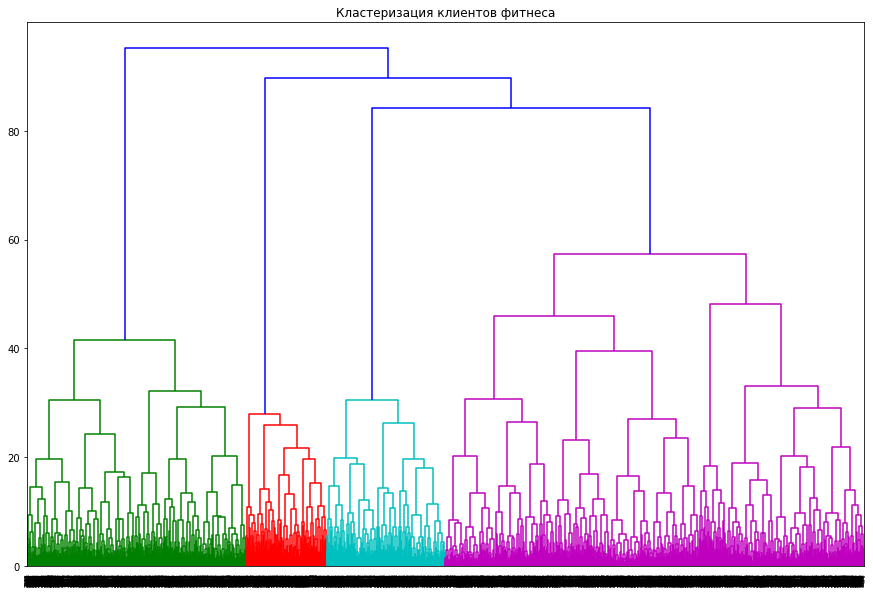

Wall time: 1min 47s


In [17]:
%%time
# стандартизация матрицы наблюдений перед кластеризацией
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# матрица расстояний для получения дендрограммы
linked = linkage(X_sc, method = 'ward')

# построение дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнеса')
plt.show()

### Обучение модели с K-means

In [18]:
# задаём модель K-means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0) 

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# добавляем разметку по кластерам в датасет
data['cluster_km'] = labels

### Распределение признаков для кластеров

#### Распределение средних значений признаков по кластерам

In [19]:
# средние значения признаков для кластеров
data.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.492000,0.994000,0.953000,1.000000,0.906000,7.346000,0.528000,29.633000,154.086252,6.730000,4.287000,1.960141,1.919105,0.108000
1,0.495352,0.998672,0.378486,0.046481,0.903054,5.059761,0.000000,30.342629,174.392898,4.698539,5.166003,2.240956,2.237272,0.046481
2,0.510507,1.000000,0.224969,0.114957,0.899876,1.797281,0.187886,26.800989,111.061687,1.710754,1.422744,1.330053,0.984420,0.740420
3,0.502455,0.000000,0.489362,0.072013,0.913257,2.996727,0.232406,28.700491,137.375245,2.826514,3.027823,1.768079,1.599583,0.400982
4,0.551391,0.998791,0.275695,0.074970,0.897219,5.180169,1.000000,30.275695,155.484435,4.730351,4.499395,2.070362,2.044372,0.089480


<a id="clustering-conclusion"></a>
**Выводы по средним значениям для кластеров**  
Кластеры различаются по оттоку.  
Самый большой отток у кластеров 2 и 3, где:
- осталось в среднем 2 и менее месяца до завершения контракта;
- самая низкая посещаемость в общем и за последний месяц — 0.98 и 1.59;
- самые низкие сопутствующие траты — 111 и 137;
- кластеры с высоким значением оттока в среднем моложе — 26.8 и 28.7 лет против 29 и 30.

#### Распределения значений по каждому кластеру для клиентов в оттоке и нет

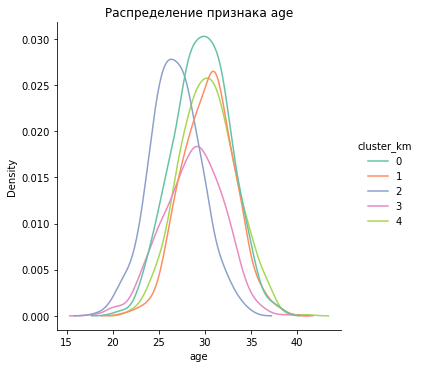

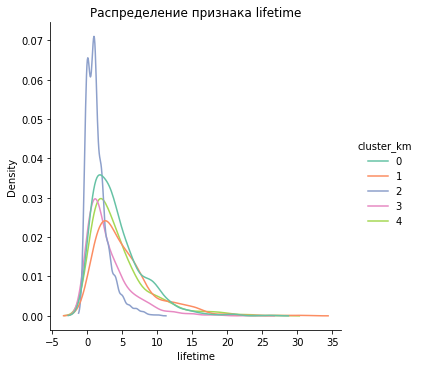

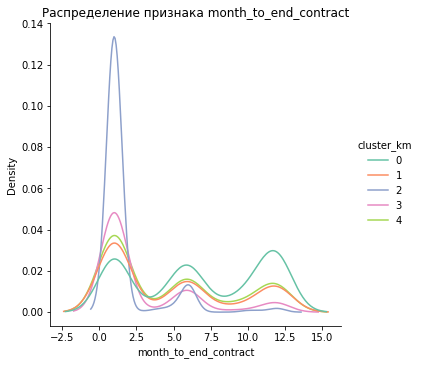

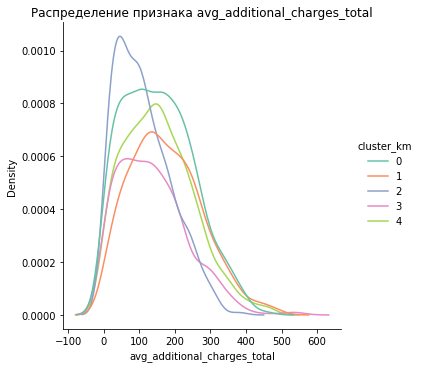

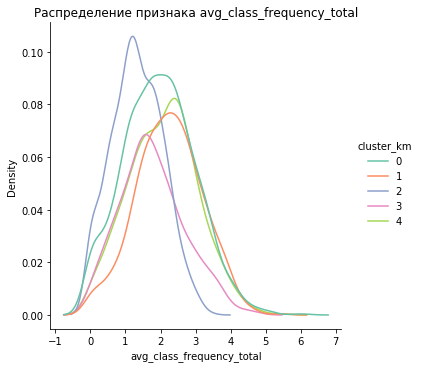

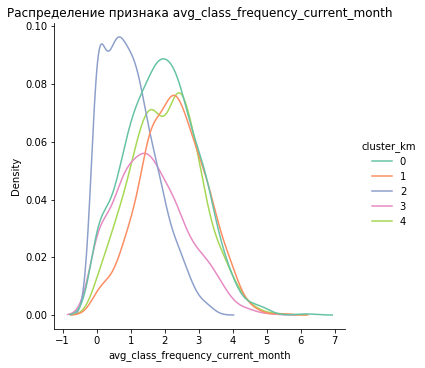

In [20]:
# графики для категориальных переменных
for column in numeric_cols:
    sns.displot(
        x = data[column],
        hue='cluster_km',
        kind="kde",
        data=data,
        palette='Set2'
    )
    plt.title('Распределение признака ' + column)
    plt.show()

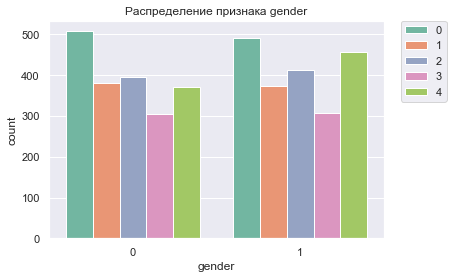

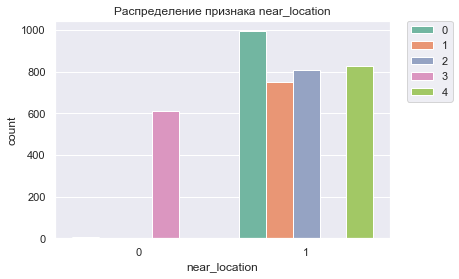

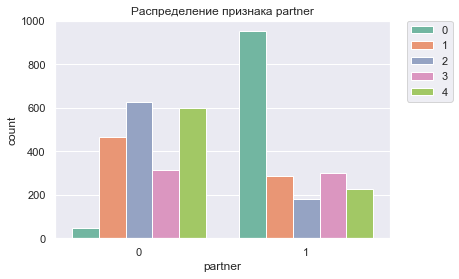

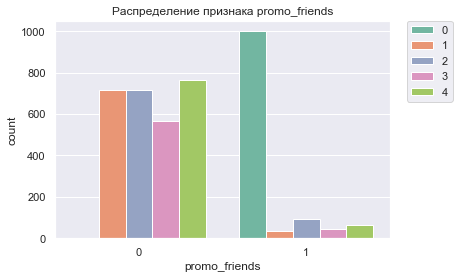

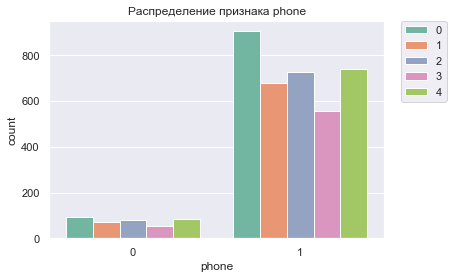

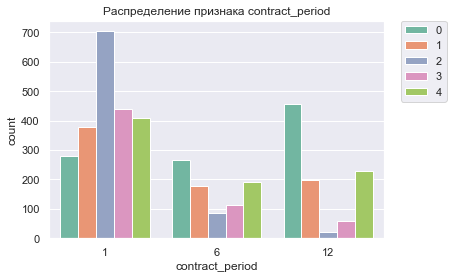

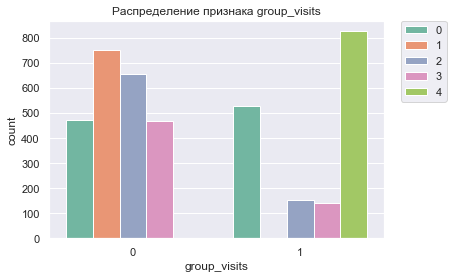

In [21]:
# графики для категориальных переменных
sns.set()
for column in categorical_cols:
    sns.countplot(x = data[column], hue='cluster_km', data=data, palette='Set2')
    plt.title('Распределение признака ' + column)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

### Описание кластеров, выводы

В этой главе структурирована аналитика из <a href="#Распределение-признаков-для-кластеров" data-toc-modified-id="Распределение-признаков-для-кластеров-4.3">предыдущего раздела</a> для описания каждого кластера в отдельности.  
Таким образом, сможем дать более конкретные рекомендации для отдела маркетинга.

#### Размеры и основные показатели

Посчитаем, сколько в среднем дополнительного дохода приносит один клиент из каждого кластера.  
И сколько доп. дохода можно потерять по каждому кластеру (помимо стоимости абонемента).  
Соберём средние показатели и посчитаем дополнительные метрики.  

<a id="marketing-to-focus"></a>

In [22]:
# расчёт доп. метрик
churn_clusters = (
    data.groupby('cluster_km', as_index=False)
    .agg({
        'gender': 'count',
        'churn': 'mean',
        'age': 'mean',
        'lifetime': 'mean',
        'avg_additional_charges_total': 'mean'
    })
    .rename(columns={
        'cluster_km': 'cluster',
        'gender': 'cluster_size',
        'avg_additional_charges_total': 'avg_charges'
    })
)

# посчитаем, сколько всего денег принесли клиенты кластера
churn_clusters['charges'] = (
    round(churn_clusters['avg_charges'] * churn_clusters['lifetime'], 1)
)

# средний LTV одного клиента кластера
churn_clusters['avg_customer_LTV'] = (
    round(churn_clusters['charges'] / churn_clusters['cluster_size'], 3)
)

# вероятные потери на одного ушедшего
churn_clusters['possible_loss_per_churned_customer'] = (
    round(churn_clusters['churn'] * churn_clusters['avg_customer_LTV'], 3)
)

# вероятные потери на кластер
churn_clusters['possible_loss'] = (
    round(churn_clusters['churn'] * churn_clusters['avg_charges'], 2)
)

churn_clusters

,cluster,cluster_size,churn,age,lifetime,avg_charges,charges,avg_customer_LTV,possible_loss_per_churned_customer,possible_loss
0,0,1000,0.108000,29.633000,4.287000,154.086252,660.6,0.661,0.071,16.64
1,1,753,0.046481,30.342629,5.166003,174.392898,900.9,1.196,0.056,8.11
2,2,809,0.740420,26.800989,1.422744,111.061687,158.0,0.195,0.144,82.23
3,3,611,0.400982,28.700491,3.027823,137.375245,415.9,0.681,0.273,55.09
4,4,827,0.089480,30.275695,4.499395,155.484435,699.6,0.846,0.076,13.91


#### Самые лояльные клиенты

##### Кластер 1

- Размер кластера 753 человек.  
- Отток на уровне 0.046.   
- Средний возраст 30.34 — самый возрастной кластер.

##### Кластер 4

- Размер кластера 827 человек.  
- Отток на уровне 0.089.
- Средний возраст 30.27.

#### Средний риск оттока

##### Кластер 0

- Размер кластера 1000 человек — самый многочисленный кластер.  
- Отток на уровне 0.108.  
- Средний возраст 29.63.  

#### Высокий риск оттока

В кластерах с высоким риском оттока наблюдается снижение посещаемости за последний месяц. 

Распределение возраста в кластерах похоже на нормальное.  
От фитнеса, как и в остальных кластерах, уходят более молодые клиенты.  


##### Кластер 2

- Размер кластера 809 человек.  
- Отток на уровне 0.740.
- Средний возраст 26.80 — самый молодой кластер.

Если клиент находится в этом кластере, скорее всего он покинет фитнес в след. месяце.

##### Кластер 3

- Размер кластера 611 человека — самый малочисленный кластер.  
- Отток на уровне 0.400.  
- Средний возраст 28.70.

Отметим следующие наблюдения:  
1. Вероятность оттока из кластера 2 — 0.74, из кластера 3 — 0.40.
2. Вероятные потери на одного ушедшего клиента в кластере 2 — 0.144, в кластере 3 — 0.273.  

**Вывод**  
При условии, что <mark>затраты на удержание одного клиента одинаковы</mark>, лучше сфокусировать усилия отдела маркетинга на <mark>кластере 3</mark>.

## Выводы

### Общий вывод

Есть некоторое различие между <a href="#Обучение-модели-с-K-means" data-toc-modified-id="Обучение-модели-с-K-means-4.2">кластеризацией</a> и таблицей, где просто провели <a href="#Группировка-по-оттоку-—-'churn'" data-toc-modified-id="Группировка-по-оттоку-—-'churn'-2.2">группировку по оттоку</a>.<br>
Но в целом выводы одни и те же.  
Результат кластеризации более детальный и позволяет поработать с разными группами уходящих в отток.

### Рекомендации для бизнеса

На основании [выводов](#clustering-conclusion), полученных кластеризацией, даю несколько рекомендаций на рассмотрение бизнесу:
1. Предложить скидку на продление абонемента клиентам, контракт которых подходит к завершению. Лучше за 2 месяца до завершения текущего контракта.
2. Рекламировать групповые занятия и нанимать социально активных тренеров, к которым потянутся клиенты.
3. Предложить особые условия молодой аудитории.
4. Периодически отправлять напоминания о посещении фитнеса или о планируемом групповом занятии когортам с низкой посещаемостью.

В первую очередь стоит сфокусировать усилия отдела маркетинга на удержании клиентов из кластера 3 — [самые высокие потенциальные потери на человека](#marketing-to-focus) при прочих равных.